In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets import *
from SR_UNet_simple import SR_UNet_simple
from utils import *

torch.manual_seed(42)

In [2]:
# NUM_GPUS_TO_USE = 3

BATCH_SIZE = 256#*NUM_GPUS_TO_USE #64

In [3]:
MONTHS=[1,12]
HOURS="all"

In [11]:
train_ds = HRRR_URMA_Dataset_AllTimes_AnyDates_AnyTerrains(is_train=True,
                                                          months=MONTHS,  
                                                          hours=HOURS,
                                                          forecast_lead_time=1,
                                                          with_terrains=["hrrr","urma","diff"], #make sure this matches previous cell
                                                          with_yearly_time_sig=False, 
                                                          with_hourly_time_sig=False)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

Loading predictor dataset (Years = 2021/22/23, months = 1 to 12, hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Predictor dataset data loaded. Time taken = 29.0 sec
Loading target dataset (Same time span)
Target dataset data loaded. Time taken = 4.5 sec
[1/24] | Normalization for hour 0's data done
[2/24] | Normalization for hour 1's data done
[3/24] | Normalization for hour 2's data done
[4/24] | Normalization for hour 3's data done
[5/24] | Normalization for hour 4's data done
[6/24] | Normalization for hour 5's data done
[7/24] | Normalization for hour 6's data done
[8/24] | Normalization for hour 7's data done
[9/24] | Normalization for hour 8's data done
[10/24] | Normalization for hour 9's data done
[11/24] | Normalization for hour 10's data done
[12/24] | Normalization for hour 11's data done
[13/24] | Normalization for hour 12's data done
[14/24] | Normalization for hour 13's data done
[15/24] | Normalization for hour 14's data d

In [6]:
n_ch_in = np.shape(train_ds[0][0])[0]
model = SR_UNet_simple(n_channels_in=n_ch_in)

device = torch.device("cuda:3")
# model = nn.DataParallel(model, device_ids=[i for i in range(NUM_GPUS_TO_USE)])
model.to(device)

## Uncomment if need to load a particular model
savename = f"UNSim_BS256_NE1000_months1-12_tHRRR1_tURMA1_tDIFF1_sigYr0_sigHr0"
model.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/hrrr_CNN_testing/Trained models/UNetSimple f01 6371200 models/{savename}.pt", weights_only=True))



<All keys matched successfully>

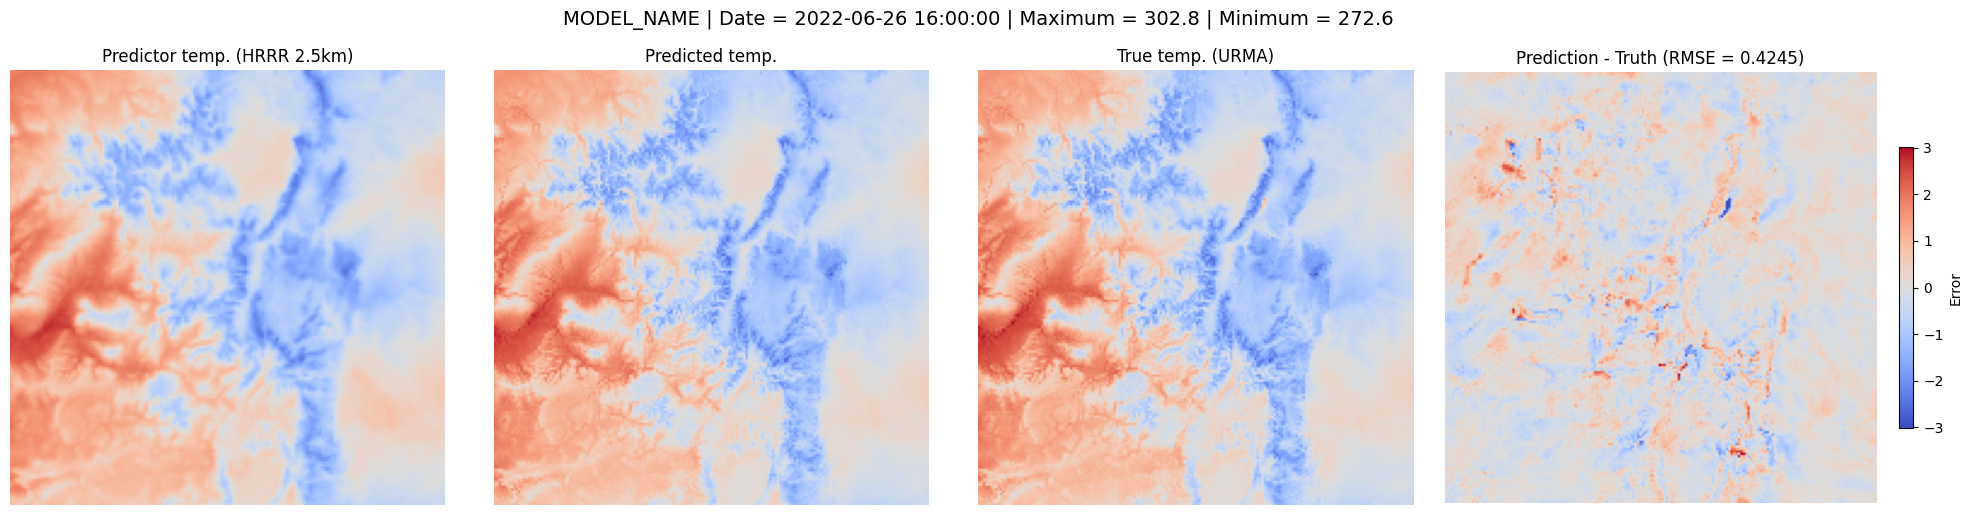

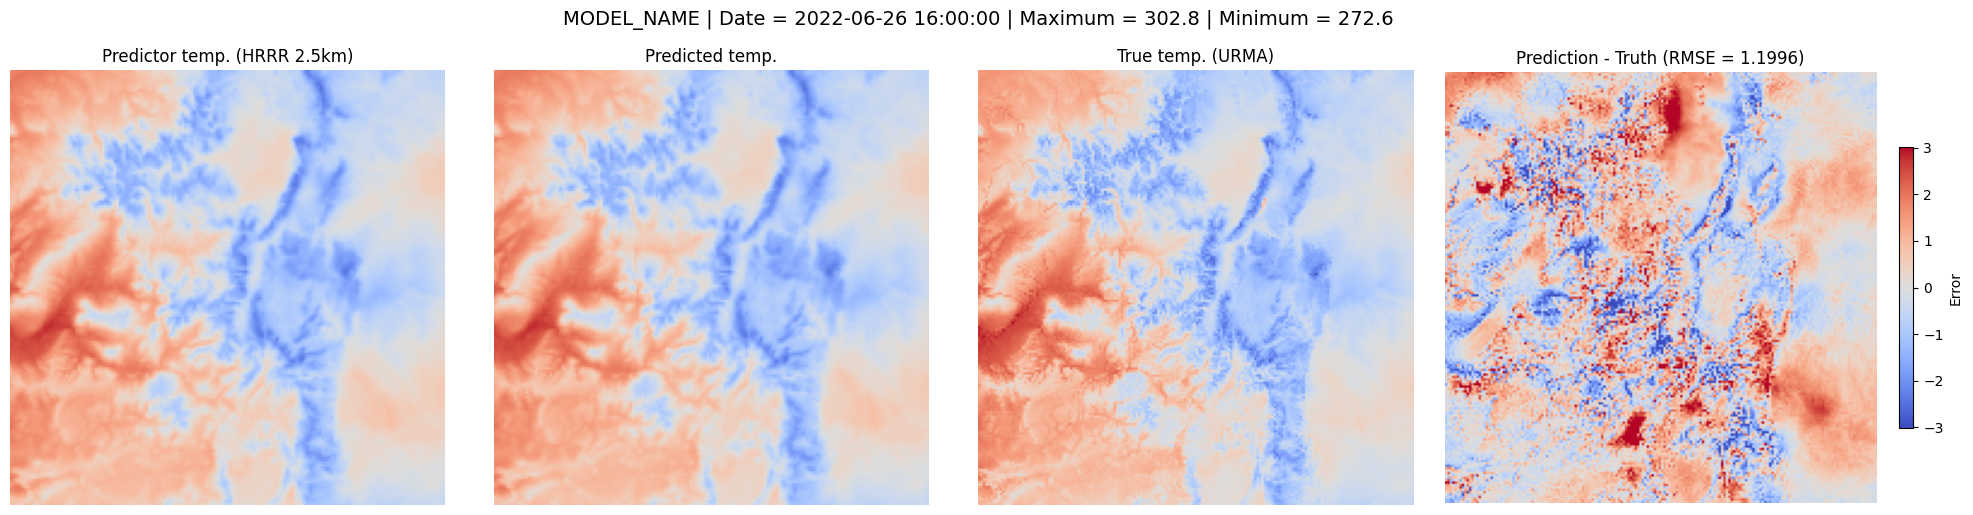

In [10]:
# play around with some examples, UN-NORMED

idx = 13000 #some random index
X,y = train_ds[idx] 
X = X[np.newaxis,:] 
X_gpu = torch.from_numpy(X).cuda(device)

with torch.no_grad():
    pred = model(X_gpu.float())
    pred = pred.cpu().numpy()

date = train_ds.xr_dataset_pred[idx].valid_time.data
dt_current = dt.datetime.strptime(str(np.datetime_as_string(date, unit='s')), "%Y-%m-%dT%H:%M:%S")
hour_idx = np.where(np.array(train_ds.hours) == dt_current.hour)[0][0] #overengineered but will work for non-"all" hours

X_unnormed = train_ds.dataset_pred_normed_stddevs[hour_idx]*X[0,0,:] + train_ds.dataset_pred_normed_means[hour_idx]
y_unnormed = train_ds.dataset_targ_normed_stddevs[hour_idx]*y + train_ds.dataset_targ_normed_means[hour_idx]
pred_unnormed = train_ds.dataset_targ_normed_stddevs[hour_idx]*pred + train_ds.dataset_targ_normed_means[hour_idx]

# plot_prediction(X[0,0,:],y,pred)
# plot_prediction(X[0,0,:],y,X[0,0,:])

plot_prediction(X_unnormed, pred_unnormed, y_unnormed, date_str=dt_current, to_save=False)
plot_prediction(X_unnormed, X_unnormed, y_unnormed, date_str=dt_current, to_save=False) #to see original's error

In [ ]:
# def plot_prediction(X,y,pred,date_str="DATE",to_save=False):
#     #X,y,pred = input data, truth, prediction respectively, as numpy arrays
#     fig, axes = plt.subplots(1,4, figsize=(20,5))
#     maxtemp = np.max([np.max(X.squeeze()), np.max(y.squeeze()), np.max(pred.squeeze())])
#     mintemp = np.min([np.min(X.squeeze()), np.min(y.squeeze()), np.min(pred.squeeze())])
#     #avg = (abs(maxtemp)+abs(mintemp))/2
#     avg = (maxtemp-mintemp)/10
    
#     axes[0].imshow(X.squeeze(), cmap="coolwarm", vmin = mintemp, vmax = maxtemp)
#     axes[0].set_title(f"Predictor temp. (HRRR 2.5km)")
#     axes[0].axis("off")
#     axes[1].imshow(pred.squeeze(), cmap="coolwarm", vmin = mintemp, vmax = maxtemp)
#     axes[1].set_title(f"Predicted temp.")
#     axes[1].axis("off")
#     axes[2].imshow(y.squeeze(), cmap="coolwarm", vmin = mintemp, vmax = maxtemp)
#     axes[2].set_title(f"True temp. (URMA)")
#     axes[2].axis("off")
#     pos = axes[3].imshow((pred.squeeze() - y.squeeze()), cmap="coolwarm", vmin = -1*avg, vmax = avg) #Note we want the error centered around zero - may need to adjust the bounds.
#     axes[3].set_title(f"Prediction - Truth")
#     axes[3].axis("off")

#     cbar = fig.colorbar(pos, ax=axes[3], fraction=0.03) #needs to be made more elegant
#     cbar.set_label('Error')
    
#     plt.suptitle(f"Date = {date_str} | Maximum = {maxtemp:.4f} | Minimum = {mintemp:.4f}", va="bottom", fontsize=14)
#     plt.tight_layout()

#     if to_save:
#         plt.savefig("temp.png",dpi=300, bbox_inches="tight")

#     plt.show()